# Inspect the properties on Wikidata

In this notebook we will inspect the different properties of Wikidata and show which ones are interesting to study in a statistical analysis.
The most essential thing to focus on is which properties are present in the maximum number of instances. It is also important that the instances share most of the properties.

To do this, we set up a query that retrieves all the properties but first we exclude the properties including an identifier (because there is no interest to study and this reduces the number of responses). We also exclude properties with too few instances (relative to the number of instances in the query). It drastically decreases the execution time of the request.

All the queries are first written on the SQLite database to keep them in memory. (to create it see. https://github.com/Semantic-Data-for-Humanities/Economists_Jurists/blob/development/Notebooks/Merge/Database_SQlite.ipynb).

In [10]:
# Import libraries usefull

    
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pprint
import csv
# from bs4 import BeautifulSoup

from collections import Counter
from operator import itemgetter
import pandas as pd

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
from collections import Counter
from operator import itemgetter

In [20]:
import sparql_functions as spqf  # It's made-home fonctions created by Francesco Beretta
# so they must to be in the same folder as this file.

SyntaxError: invalid syntax (<ipython-input-20-b95e43233e94>, line 4)

# Execution of the query

In [6]:
### It's define the database ligne to use
pk_query = 55

# Connexion to the database
original_db = '/Notebooks/Merge/data/sparql_queries.db'
conn = sql.connect(original_db)

c = conn.cursor()

### It runs the query on the SQLite database to get the row values 
c.execute('SELECT * FROM query WHERE pk_query = ?', [pk_query]) ### a list around argument is needed for a string longer then one
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchone()

# close connexion
conn.close()


NameError: name 'sql' is not defined

In [79]:
print(rc[2] +  "\n-----\n" + rc[4] +  "\n-----\n" +   rc[7]+  "\n\n\n------------------\n" +  rc[5] + "\n\n\n------------------\n")

SELECT: This query gets all the properties of legal advocate in France.
I only exclude all properties with IDs.
-----
https://query.wikidata.org/sparql
-----
2021-05-26 15:46:43


------------------
SELECT  ?prop ?propLabel ?direction ?eff ?propDescription
WHERE{ { 
        SELECT  ?prop ?propLabel ?propDescription ?direction ?eff
WHERE{
    {
  SELECT   ?prop ?direction  (COUNT(*) as ?eff) # ?pLabel
 WHERE
  { 
  hint:Query hint:optimizer "None" .
      { ?person  wdt:P106 wd:Q791243. # legal advocate in France | result : 29 people
       ?person   wdt:P569  ?birthDate;
                 ?p        ?o.
       ?prop wikibase:directClaim ?p .
       FILTER ( ?birthDate >= "1770-01-01"^^xsd:dateTime )
       BIND("out" AS ?direction)
      }
  UNION
       {
       ?person  wdt:P106  wd:Q791243.
       ?person   wdt:P569  ?birthDate .
       ?s ?p ?person.
       ?prop wikibase:directClaim ?p .
       FILTER ( ?birthDate >= "1770-01-01"^^xsd:dateTime )
       BIND("in" AS ?direction)
     

In [80]:
### Execute the SPARQL query wrapped in the function in the library _sparql_functions.py_
# The first setting correspond to SPARQL Endpoint, the seconde to the query
q = spqf.get_json_sparql_result(rc[4],rc[5])

<class 'dict'>


In [81]:
### This fonction retrieves and shapes time

# definition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# execution
timestamp_formatted_for_file_name()

'20210601_104540'

In [82]:
# Define the file addresses, the existing one and new one
original_db = 'data/sparql_queries.db'

timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [83]:
## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(original_db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210601_104542.sqlite'

In [84]:
### store the answer of the SPARQL endpoint in the 'result'

conn = sql.connect(original_db)
c = conn.cursor()
values = (pk_query, str(q),timestamp_formatted_for_file_name())

# https://www.techonthenet.com/sqlite/functions/now.php
c.execute("INSERT INTO result (fk_query, result, timestmp) VALUES (?,?,?)", values)
# commit the insertion and close the database
# !! REQUIRE to be enabled to commit to the SQLite database !!
conn.commit()
conn.close()

# Inspect the queries

In [85]:
### Inspect the resultat after an insert

# Choose the row of the database to get
pk_result = ('15')

# connexion to the database
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

### execute the query on the SQLite database to retrieve the values of the row
c = conn.cursor()
c.execute('SELECT * FROM result WHERE pk_result = ?', (pk_result,))
result_q = c.fetchone()

# close connexion
conn.close()
# result_q[3]

In [86]:
### Transform string to dict
## Doc.:
# https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
import ast
d = ast.literal_eval(result_q[3])
type(d)

dict

In [87]:
##### Transform the result into a list with a fonction of the library #####

#### Result of the query
r_query = [l for l in spqf.sparql_result_to_list(d)]
print(len(r_query))
r_query

74


[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '55',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '55',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '47',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '33',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '32',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '30',
  'award or recognition received by a person, organisati

## Economist

In this query, we exclude the properties with less of 5000 in number.
In total, There is 29322 instances

``
 [['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '73909',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '62166',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '35783',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '35078',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '31125',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '30317',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '28166',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '26894',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '20250',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '19451',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '18100',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '17333',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '16075',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '14657',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P184',
  'doctoral advisor',
  'in',
  '14250',
  'person who supervised the doctorate or PhD thesis of the subject'],
 ['http://www.wikidata.org/entity/P185',
  'doctoral student',
  'out',
  '14016',
  'doctoral student(s) of a professor'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '11349',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '10821',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '8892',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '6947',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '6532',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '6217',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '5498',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '5071',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '5038',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")']]
 ``

## Jurist

In this query, we exclude the properties with less of 5000 in number.
In total, There is 24886 instances

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '66370',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '32159',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '31979',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '30705',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '30196',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '23810',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '22410',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '22330',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '17743',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '15211',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '13590',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '13225',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '12841',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '12196',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '11911',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '9301',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '9187',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '7102',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '7028',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '5288',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '5034',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).']]
``

## Lawyers

In this query, we exclude the properties with less of 5000 in number.
In total, There is 68033 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '164404',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '76557',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '75759',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '71898',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '70830',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '67515',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '65987',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '65664',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '54151',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '47430',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '41406',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '37867',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '33976',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '29448',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '28924',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '20170',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '18466',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '18032',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '17961',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '15770',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '14027',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '9979',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '7880',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '7494',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '7040',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '6769',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'in',
  '6351',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P119',
  'place of burial',
  'out',
  '6310',
  'location of grave, resting place, place of ash-scattering, etc. (e.g., town/city or cemetery) for a person or animal. There may be several places: e.g., re-burials, parts of body buried separately.']]
``

## Judge
In this query, we exclude the properties with less of 5000 in number.
In total, There is 68033 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '72138',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '36347',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '35776',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '34257',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '32572',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '30312',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '28203',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '26290',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '23809',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '21896',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '16535',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '14787',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '11530',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '9935',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '9263',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P1594',
  'judge',
  'in',
  '9088',
  'judge, magistrate or equivalent, presiding at a trial'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '8826',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '7878',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '6682',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '5684',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '5661',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '5649',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '5085',
  'person or organization for which the subject works or worked']]
``

## Attorney

In total, There is 100 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '283',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '129',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '125',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '124',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '124',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '114',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '111',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '93',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '65',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '61',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '50',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '46',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '45',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '41',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '33',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '31',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '28',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '22',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '18',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P1343',
  'described by source',
  'out',
  '17',
  'work where this item is described'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '15',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P551',
  'residence',
  'out',
  '14',
  'the place where the person is or has been, resident'],
 ['http://www.wikidata.org/entity/P1477',
  'birth name',
  'out',
  '12',
  'full name of a person at birth, if different from their current, generally used name (samples: John Peter Doe for Joe Doe, Ann Smith for Ann Miller)'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '12',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '11',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P119',
  'place of burial',
  'out',
  '11',
  'location of grave, resting place, place of ash-scattering, etc. (e.g., town/city or cemetery) for a person or animal. There may be several places: e.g., re-burials, parts of body buried separately.'],
 ['http://www.wikidata.org/entity/P509',
  'cause of death',
  'out',
  '11',
  "underlying or immediate cause of death.  Underlying cause (e.g. car accident, stomach cancer) preferred.  Use 'manner of death' (P1196) for broadest category, e.g. natural causes, accident, homicide, suicide"],
 ['http://www.wikidata.org/entity/P138',
  'named after',
  'in',
  '10',
  'entity or event that inspired the subject\'s name, or namesake (in at least one language). Qualifier "applies to name" (P5168) can be used to indicate which one'],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'out',
  '10',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '10',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P921',
  'main subject',
  'in',
  '9',
  'primary topic of a work (see also P180: depicts)'],
 ['http://www.wikidata.org/entity/P140',
  'religion',
  'out',
  '9',
  'religion of a person, organization or religious building, or associated with this subject'],
 ['http://www.wikidata.org/entity/P1196',
  'manner of death',
  'out',
  '9',
  "general circumstances of a person's death; e.g. natural causes, accident, suicide, homicide, etc.  Use 'cause of death' (P509) for the specific physiological mechanism, e.g. heart attack, trauma, pneumonia..."],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'in',
  '8',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions'],
 ['http://www.wikidata.org/entity/P856',
  'official website',
  'out',
  '8',
  'URL of the official homepage of an item (current or former) [if the homepage changes, add an additional statement with preferred rank. Do not remove the former URL]'],
 ['http://www.wikidata.org/entity/P5008',
  'on focus list of Wikimedia project',
  'out',
  '7',
  'property to indicate that an item is of particular interest for a Wikimedia project. This property does not add notability. Items should not be created with this property if they are not notable for Wikidata. See also P6104, P972, P2354.'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '7',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P1442',
  'image of grave',
  'out',
  '7',
  "picture of a person or animal's grave, gravestone or tomb"],
 ['http://www.wikidata.org/entity/P112',
  'founded by',
  'in',
  '6',
  'founder or co-founder of this organization, religion or place'],
 ['http://www.wikidata.org/entity/P1441',
  'present in work',
  'out',
  '6',
  'this (fictional or fictionalized) entity or person appears in that work as part of the narration (use P2860 for works citing other works, P361/P1433 for works being part of other works, P1343 for entities described in non-fictional accounts)'],
 ['http://www.wikidata.org/entity/P710',
  'participant',
  'in',
  '6',
  'person, group of people or organization (object) that actively takes/took part in an event or process (subject).  Preferably qualify with "object has role" (P3831). Use P1923 for participants that are teams.'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '6',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P101',
  'field of work',
  'out',
  '6',
  'specialization of a person or organization; see P106 for the occupation'],
 ['http://www.wikidata.org/entity/P1971',
  'number of children',
  'out',
  '6',
  'number of children of the person'],
 ['http://www.wikidata.org/entity/P25',
  'mother',
  'in',
  '5',
  'female parent of the subject. For stepmother, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P512',
  'academic degree',
  'out',
  '5',
  'academic degree that the person holds'],
 ['http://www.wikidata.org/entity/P161',
  'cast member',
  'in',
  '4',
  'actor in the subject production [use "character role" (P453) and/or "name of the character role" (P4633) as qualifiers] [use "voice actor" (P725) for voice-only role]'],
 ['http://www.wikidata.org/entity/P674',
  'characters',
  'in',
  '4',
  'characters which appear in this item (like plays, operas, operettas, books, comics, films, TV series, video games)'],
 ['http://www.wikidata.org/entity/P175',
  'performer',
  'out',
  '4',
  'actor, musician, band or other performer associated with this role or musical work'],
 ['http://www.wikidata.org/entity/P170',
  'creator',
  'out',
  '4',
  'maker of this creative work or other object (where no more specific property exists). Paintings with unknown painters, use "anonymous" (Q4233718) as value.'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'in',
  '4',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P1344',
  'participant in',
  'out',
  '4',
  'event in which a person or organization was/is a participant; inverse of P710 or P1923'],
 ['http://www.wikidata.org/entity/P172',
  'ethnic group',
  'out',
  '4',
  "subject's ethnicity (consensus is that a VERY high standard of proof is needed for this field to be used. In general this means 1) the subject claims it themself, or 2) it is widely agreed on by scholars, or 3) is fictional and portrayed as such)"],
 ['http://www.wikidata.org/entity/P742',
  'pseudonym',
  'out',
  '4',
  'alias used by someone (for nickname use P1449)'],
 ['http://www.wikidata.org/entity/P1950',
  'second family name in Spanish name',
  'out',
  '4',
  'second (generally maternal) family name in Spanish names (do not use for other double barrelled names)'],
 ['http://www.wikidata.org/entity/P973',
  'described at URL',
  'out',
  '3',
  'item is described at the following URL'],
 ['http://www.wikidata.org/entity/P641',
  'sport',
  'out',
  '3',
  'sport that the subject participates or participated in or is associated with'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'out',
  '3',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P8687',
  'social media followers',
  'out',
  '3',
  'number of subscribers on a particular social media website (use as main statement only; see P3744 instead for qualifier). Qualify with "point in time" and property for account. For Twitter, use numeric id.'],
 ['http://www.wikidata.org/entity/P2002',
  'Twitter username',
  'out',
  '3',
  "this item's username on Twitter; do not include the “@” symbol"],
 ['http://www.wikidata.org/entity/P1225',
  'U.S. National Archives Identifier',
  'out',
  '3',
  "identifier for the United States National Archives and Records Administration's online catalog"],
 ['http://www.wikidata.org/entity/P6886',
  'writing language',
  'out',
  '2',
  'language in which the writer has written their work'],
 ['http://www.wikidata.org/entity/P1472',
  'Commons Creator page',
  'out',
  '2',
  'name of Commons Infobox template residing in "Creator" namespace on Wikimedia Commons'],
 ['http://www.wikidata.org/entity/P8017',
  'generational suffix',
  'out',
  '2',
  'suffix used in name'],
 ['http://www.wikidata.org/entity/P1321',
  'place of origin (Switzerland)',
  'out',
  '2',
  "lieu d'origine/Heimatort/luogo d'origine of a Swiss national. Not be confused with place of birth or place of residence"],
 ['http://www.wikidata.org/entity/P97',
  'noble title',
  'out',
  '2',
  'titles held by the person'],
 ['http://www.wikidata.org/entity/P109',
  'signature',
  'out',
  '2',
  "image of a person's signature"],
 ['http://www.wikidata.org/entity/P103',
  'native language',
  'out',
  '2',
  'language or languages a person has learned from early childhood'],
 ['http://www.wikidata.org/entity/P127',
  'owned by',
  'in',
  '2',
  'owner of the subject'],
 ['http://www.wikidata.org/entity/P136',
  'genre',
  'out',
  '2',
  "creative work's genre or an artist's field of work (P101). Use main subject (P921) to relate creative works to their topic"],
 ['http://www.wikidata.org/entity/P485',
  'archives at',
  'out',
  '2',
  "the institution holding the subject's archives"],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'out',
  '2',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P2031',
  'work period (start)',
  'out',
  '2',
  'start of period during which a person or group flourished (fl. = "floruit") in their professional activity'],
 ['http://www.wikidata.org/entity/P1830',
  'owner of',
  'out',
  '2',
  'entities owned by the subject'],
 ['http://www.wikidata.org/entity/P1532',
  'country for sport',
  'out',
  '1',
  'country a person or a team represents when playing a sport'],
 ['http://www.wikidata.org/entity/P805',
  'statement is subject of',
  'out',
  '1',
  '(qualifying) item that describes the relation identified in this statement'],
 ['http://www.wikidata.org/entity/P112',
  'founded by',
  'out',
  '1',
  'founder or co-founder of this organization, religion or place'],
 ['http://www.wikidata.org/entity/P451',
  'unmarried partner',
  'in',
  '1',
  'someone with whom the person is in a relationship without being married. Use "spouse" (P26) for married couples'],
 ['http://www.wikidata.org/entity/P57',
  'director',
  'in',
  '1',
  'director(s) of film, TV-series, stageplay, video game or similar'],
 ['http://www.wikidata.org/entity/P451',
  'unmarried partner',
  'out',
  '1',
  'someone with whom the person is in a relationship without being married. Use "spouse" (P26) for married couples'],
 ['http://www.wikidata.org/entity/P361',
  'part of',
  'out',
  '1',
  'object of which the subject is a part (if this subject is already part of object A which is a part of object B, then please only make the subject part of object A). Inverse property of "has part" (P527, see also "has parts of the class" (P2670)).'],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'in',
  '1',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P527',
  'has part',
  'in',
  '1',
  'part of this subject; inverse property of "part of" (P361). See also "has parts of the class" (P2670).'],
 ['http://www.wikidata.org/entity/P162',
  'producer',
  'in',
  '1',
  'person(s) who produced the film, musical work, theatrical production, etc. (for film, this does not include executive producers, associate producers, etc.) [for production company, use P272, video games - use P178]'],
 ['http://www.wikidata.org/entity/P25',
  'mother',
  'out',
  '1',
  'female parent of the subject. For stepmother, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'in',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P344',
  'director of photography',
  'in',
  '1',
  'person responsible for the framing, lighting, and filtration of the subject work'],
 ['http://www.wikidata.org/entity/P157',
  'killed by',
  'in',
  '1',
  'person who killed the subject'],
 ['http://www.wikidata.org/entity/P7763',
  'copyright status as a creator',
  'out',
  '1',
  'states if the body of work published during the lifetime of this creator is still copyrighted or in the public domain'],
 ['http://www.wikidata.org/entity/P607',
  'conflict',
  'out',
  '1',
  'battles, wars or other military engagements in which the person or item participated'],
 ['http://www.wikidata.org/entity/P241',
  'military branch',
  'out',
  '1',
  'branch to which this military unit, award, office, or person belongs, e.g. Royal Navy'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'out',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P5821',
  'ArhivX LOD',
  'out',
  '1',
  'Croatian art/theater linked open data'],
 ['http://www.wikidata.org/entity/P767',
  'contributor to the creative work or subject',
  'in',
  '1',
  'person or organization that contributed to a subject: co-creator of a creative work or subject'],
 ['http://www.wikidata.org/entity/P6241',
  'collection creator',
  'in',
  '1',
  'entity (person, organization, etc.) that caused a record or collection to be produced or gathered'],
 ['http://www.wikidata.org/entity/P5052',
  'supervisory board member',
  'in',
  '1',
  'member(s) of the supervisory board for the organization'],
 ['http://www.wikidata.org/entity/P1365',
  'replaces',
  'in',
  '1',
  'person, state or item replaced. Use "structure replaces" (P1398) for structures. Use "follows" (P155) if the previous item was not replaced or predecessor and successor are identical'],
 ['http://www.wikidata.org/entity/P2003',
  'Instagram username',
  'out',
  '1',
  "item's username on Instagram"],
 ['http://www.wikidata.org/entity/P1080',
  'from narrative universe',
  'out',
  '1',
  "subject's fictional entity is in the object narrative. See also P1441 (present in work) and P1445 (fictional universe described in)"],
 ['http://www.wikidata.org/entity/P54',
  'member of sports team',
  'out',
  '1',
  'sports teams or clubs that the subject currently represents or formerly represented'],
 ['http://www.wikidata.org/entity/P91',
  'sexual orientation',
  'out',
  '1',
  'the sexual orientation of the person — use IF AND ONLY IF they have stated it themselves, unambiguously, or it has been widely agreed upon by historians after their death'],
 ['http://www.wikidata.org/entity/P3342',
  'significant person',
  'out',
  '1',
  'person linked to the item in any possible way'],
 ['http://www.wikidata.org/entity/P511',
  'honorific prefix',
  'out',
  '1',
  'word or expression used before a name, in addressing or referring to a person'],
 ['http://www.wikidata.org/entity/P4966',
  'Hungarian National Assembly identifier',
  'out',
  '1',
  'identifier for a past or present member or office-holder of the Hungarian Parliament'],
 ['http://www.wikidata.org/entity/P1366',
  'replaced by',
  'out',
  '1',
  'other person or item which continues the item by replacing it in its role. Use P156 (followed by) if the item is not replaced (e.g. books in a series), nor identical, but adds to the series without dropping the role of this item in that series'],
 ['http://www.wikidata.org/entity/P800',
  'notable work',
  'out',
  '1',
  "notable scientific, artistic or literary work, or other work of significance among subject's works"],
 ['http://www.wikidata.org/entity/P1037',
  'director / manager',
  'in',
  '1',
  'person who manages any kind of group'],
 ['http://www.wikidata.org/entity/P488',
  'chairperson',
  'in',
  '1',
  'presiding member of an organization, group or body'],
 ['http://www.wikidata.org/entity/P98',
  'editor',
  'in',
  '1',
  'editor of a compiled work such as a book or a periodical (newspaper or an academic journal)'],
 ['http://www.wikidata.org/entity/P767',
  'contributor to the creative work or subject',
  'out',
  '1',
  'person or organization that contributed to a subject: co-creator of a creative work or subject'],
 ['http://www.wikidata.org/entity/P2632',
  'place of detention',
  'out',
  '1',
  'place where this person is or was detained'],
 ['http://www.wikidata.org/entity/P1268',
  'represents',
  'out',
  '1',
  'organization, individual, or concept that an entity represents']]
``

## Advocate

In this query, we exclude the properties with less of 100 in number.
In total, There is 702 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '2177',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '883',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '876',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '813',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '748',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '607',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '527',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '515',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '506',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '434',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '383',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '323',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '271',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '249',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '183',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '165',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '159',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '155',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P1592',
  'prosecutor',
  'in',
  '137',
  'person representing the prosecuting authority, at a trial'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '137',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '131',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '123',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '109',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P512',
  'academic degree',
  'out',
  '107',
  'academic degree that the person holds'],
 ['http://www.wikidata.org/entity/P551',
  'residence',
  'out',
  '106',
  'the place where the person is or has been, resident']]
``

## Magistrate

In this query, we exclude the properties with less of 10 in number.
In total, There is 77 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '175',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '141',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '126',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '121',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '118',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '102',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '99',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '88',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '86',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '76',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '72',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '54',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '44',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '37',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '26',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P1477',
  'birth name',
  'out',
  '23',
  'full name of a person at birth, if different from their current, generally used name (samples: John Peter Doe for Joe Doe, Ann Smith for Ann Miller)'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '21',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '18',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '14',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '13',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script']]
``

## Legal advocate in France

In total, There is 29 instances.

``
[['http://www.wikidata.org/entity/P106',
  'occupation',
  'out',
  '55',
  'occupation of a person; see also "field of work" (Property:P101), "position held" (Property:P39)'],
 ['http://www.wikidata.org/entity/P39',
  'position held',
  'out',
  '55',
  'subject currently or formerly holds the object position or public office'],
 ['http://www.wikidata.org/entity/P69',
  'educated at',
  'out',
  '47',
  'educational institution attended by subject'],
 ['http://www.wikidata.org/entity/P1412',
  'languages spoken, written or signed',
  'out',
  '33',
  'language(s) that a person or a people speaks, writes or signs, including the native language(s)'],
 ['http://www.wikidata.org/entity/P735',
  'given name',
  'out',
  '32',
  "first name or another given name of this person; values used with the property shouldn't link disambiguations nor family names."],
 ['http://www.wikidata.org/entity/P166',
  'award received',
  'out',
  '30',
  'award or recognition received by a person, organisation or creative work'],
 ['http://www.wikidata.org/entity/P569',
  'date of birth',
  'out',
  '29',
  'date on which the subject was born'],
 ['http://www.wikidata.org/entity/P31',
  'instance of',
  'out',
  '29',
  'that class of which this subject is a particular example and member'],
 ['http://www.wikidata.org/entity/P21',
  'sex or gender',
  'out',
  '29',
  'sex or gender identity of human or animal. For human: male, female, non-binary, intersex, transgender female, transgender male, agender. For animal: male organism, female organism. Groups of same gender use subclass of (P279)'],
 ['http://www.wikidata.org/entity/P27',
  'country of citizenship',
  'out',
  '28',
  'the object is a country that recognizes the subject as its citizen'],
 ['http://www.wikidata.org/entity/P734',
  'family name',
  'out',
  '24',
  'part of full name of person'],
 ['http://www.wikidata.org/entity/P19',
  'place of birth',
  'out',
  '24',
  'most specific known (e.g. city instead of country, or hospital instead of city) birth location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P101',
  'field of work',
  'out',
  '19',
  'specialization of a person or organization; see P106 for the occupation'],
 ['http://www.wikidata.org/entity/P213',
  'ISNI',
  'out',
  '14',
  'International Standard Name Identifier for an identity. Format: 4 blocks of 4 digits separated by a space, first block is 0000'],
 ['http://www.wikidata.org/entity/P570',
  'date of death',
  'out',
  '11',
  'date on which the subject died'],
 ['http://www.wikidata.org/entity/P108',
  'employer',
  'out',
  '10',
  'person or organization for which the subject works or worked'],
 ['http://www.wikidata.org/entity/P463',
  'member of',
  'out',
  '10',
  'organization, club or musical group to which the subject belongs. Do not use for membership in ethnic or social groups, nor for holding a position such as a member of parliament (use P39 for that).'],
 ['http://www.wikidata.org/entity/P1559',
  'name in native language',
  'out',
  '9',
  'name of a person in their native language. Could be displayed in addition to the label, if language has a different script'],
 ['http://www.wikidata.org/entity/P18',
  'image',
  'out',
  '9',
  'image of relevant illustration of the subject; if available, use more specific properties (sample: coat of arms image, locator map, flag image, signature image, logo image, collage image)'],
 ['http://www.wikidata.org/entity/P20',
  'place of death',
  'out',
  '8',
  'most specific known (e.g. city instead of country, or hospital instead of city) death location of a person, animal or fictional character'],
 ['http://www.wikidata.org/entity/P937',
  'work location',
  'out',
  '7',
  'location where persons were active'],
 ['http://www.wikidata.org/entity/P373',
  'Commons category',
  'out',
  '7',
  'name of the Wikimedia Commons category containing files related to this item (without the prefix "Category:")'],
 ['http://www.wikidata.org/entity/P103',
  'native language',
  'out',
  '7',
  'language or languages a person has learned from early childhood'],
 ['http://www.wikidata.org/entity/P102',
  'member of political party',
  'out',
  '6',
  'the political party of which this politician is or has been a member or otherwise affiliated'],
 ['http://www.wikidata.org/entity/P50',
  'author',
  'in',
  '5',
  'main creator(s) of a written work (use on works, not humans); use P2093 when Wikidata item is unknown or does not exist'],
 ['http://www.wikidata.org/entity/P2031',
  'work period (start)',
  'out',
  '5',
  'start of period during which a person or group flourished (fl. = "floruit") in their professional activity'],
 ['http://www.wikidata.org/entity/P1477',
  'birth name',
  'out',
  '5',
  'full name of a person at birth, if different from their current, generally used name (samples: John Peter Doe for Joe Doe, Ann Smith for Ann Miller)'],
 ['http://www.wikidata.org/entity/P8687',
  'social media followers',
  'out',
  '3',
  'number of subscribers on a particular social media website (use as main statement only; see P3744 instead for qualifier). Qualify with "point in time" and property for account. For Twitter, use numeric id.'],
 ['http://www.wikidata.org/entity/P2002',
  'Twitter username',
  'out',
  '3',
  "this item's username on Twitter; do not include the “@” symbol"],
 ['http://www.wikidata.org/entity/P3602',
  'candidacy in election',
  'out',
  '3',
  'election where the subject is a candidate'],
 ['http://www.wikidata.org/entity/P973',
  'described at URL',
  'out',
  '3',
  'item is described at the following URL'],
 ['http://www.wikidata.org/entity/P1038',
  'relative',
  'in',
  '3',
  'family member (qualify with "type of kinship", P1039; for direct family member please use specific property)'],
 ['http://www.wikidata.org/entity/P488',
  'chairperson',
  'in',
  '3',
  'presiding member of an organization, group or body'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'in',
  '3',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P485',
  'archives at',
  'out',
  '3',
  "the institution holding the subject's archives"],
 ['http://www.wikidata.org/entity/P241',
  'military branch',
  'out',
  '3',
  'branch to which this military unit, award, office, or person belongs, e.g. Royal Navy'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'out',
  '3',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P512',
  'academic degree',
  'out',
  '3',
  'academic degree that the person holds'],
 ['http://www.wikidata.org/entity/P812',
  'academic major',
  'out',
  '2',
  'subject someone studied at college/university'],
 ['http://www.wikidata.org/entity/P6886',
  'writing language',
  'out',
  '2',
  'language in which the writer has written their work'],
 ['http://www.wikidata.org/entity/P1472',
  'Commons Creator page',
  'out',
  '2',
  'name of Commons Infobox template residing in "Creator" namespace on Wikimedia Commons'],
 ['http://www.wikidata.org/entity/P527',
  'has part',
  'in',
  '2',
  'part of this subject; inverse property of "part of" (P361). See also "has parts of the class" (P2670).'],
 ['http://www.wikidata.org/entity/P185',
  'doctoral student',
  'in',
  '2',
  'doctoral student(s) of a professor'],
 ['http://www.wikidata.org/entity/P22',
  'father',
  'in',
  '2',
  'male parent of the subject. For stepfather, use "stepparent" (P3448)'],
 ['http://www.wikidata.org/entity/P40',
  'child',
  'out',
  '2',
  'subject has object as child. Do not use for stepchildren'],
 ['http://www.wikidata.org/entity/P1038',
  'relative',
  'out',
  '2',
  'family member (qualify with "type of kinship", P1039; for direct family member please use specific property)'],
 ['http://www.wikidata.org/entity/P742',
  'pseudonym',
  'out',
  '2',
  'alias used by someone (for nickname use P1449)'],
 ['http://www.wikidata.org/entity/P1196',
  'manner of death',
  'out',
  '2',
  "general circumstances of a person's death; e.g. natural causes, accident, suicide, homicide, etc.  Use 'cause of death' (P509) for the specific physiological mechanism, e.g. heart attack, trauma, pneumonia..."],
 ['http://www.wikidata.org/entity/P509',
  'cause of death',
  'out',
  '2',
  "underlying or immediate cause of death.  Underlying cause (e.g. car accident, stomach cancer) preferred.  Use 'manner of death' (P1196) for broadest category, e.g. natural causes, accident, homicide, suicide"],
 ['http://www.wikidata.org/entity/P800',
  'notable work',
  'out',
  '2',
  "notable scientific, artistic or literary work, or other work of significance among subject's works"],
 ['http://www.wikidata.org/entity/P184',
  'doctoral advisor',
  'out',
  '2',
  'person who supervised the doctorate or PhD thesis of the subject'],
 ['http://www.wikidata.org/entity/P7060',
  'NosSénateurs.fr identifier',
  'out',
  '1',
  'identifier for french deputies in NosSénateurs.fr'],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'in',
  '1',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P1855',
  'Wikidata property example',
  'in',
  '1',
  'example where this Wikidata property is used; target item is one that would use this property, with qualifier the property being described given the associated value'],
 ['http://www.wikidata.org/entity/P1037',
  'director / manager',
  'in',
  '1',
  'person who manages any kind of group'],
 ['http://www.wikidata.org/entity/P921',
  'main subject',
  'in',
  '1',
  'primary topic of a work (see also P180: depicts)'],
 ['http://www.wikidata.org/entity/P161',
  'cast member',
  'in',
  '1',
  'actor in the subject production [use "character role" (P453) and/or "name of the character role" (P4633) as qualifiers] [use "voice actor" (P725) for voice-only role]'],
 ['http://www.wikidata.org/entity/P2032',
  'work period (end)',
  'out',
  '1',
  'end of period during which a person or group flourished (fl. = "floruit") in their professional activity'],
 ['http://www.wikidata.org/entity/P1889',
  'different from',
  'out',
  '1',
  'item that is different from another item, with which it is often confused'],
 ['http://www.wikidata.org/entity/P553',
  'website account on',
  'out',
  '1',
  'website that the person or organization has an account on (use with P554) Note: only used with reliable source or if the person or organization disclosed it.'],
 ['http://www.wikidata.org/entity/P140',
  'religion',
  'out',
  '1',
  'religion of a person, organization or religious building, or associated with this subject'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'in',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P2679',
  'author of foreword',
  'in',
  '1',
  "person who wrote the preface, foreword, or introduction of the book but who isn't an author of the rest of the book"],
 ['http://www.wikidata.org/entity/P1591',
  'defendant',
  'in',
  '1',
  'person or organization accused, at a trial'],
 ['http://www.wikidata.org/entity/P664',
  'organizer',
  'in',
  '1',
  'person or institution organizing an event'],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'in',
  '1',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions'],
 ['http://www.wikidata.org/entity/P4033',
  'Mastodon address',
  'out',
  '1',
  "address on the Mastodon decentralized social network. The form is: 'user@server.domain' there is no leading '@' as sometimes written to distinguish Mastodon addresses from email addresses."],
 ['http://www.wikidata.org/entity/P1581',
  'official blog',
  'out',
  '1',
  'URL to the blog of this person or organization'],
 ['http://www.wikidata.org/entity/P793',
  'significant event',
  'out',
  '1',
  'significant or notable events associated with the subject'],
 ['http://www.wikidata.org/entity/P641',
  'sport',
  'out',
  '1',
  'sport that the subject participates or participated in or is associated with'],
 ['http://www.wikidata.org/entity/P7763',
  'copyright status as a creator',
  'out',
  '1',
  'states if the body of work published during the lifetime of this creator is still copyrighted or in the public domain'],
 ['http://www.wikidata.org/entity/P3373',
  'sibling',
  'out',
  '1',
  'the subject has the object as their sibling (brother, sister, etc.). Use "relative" (P1038) for siblings-in-law (brother-in-law, sister-in-law, etc.) and step-siblings (step-brothers, step-sisters, etc.)'],
 ['http://www.wikidata.org/entity/P410',
  'military rank',
  'out',
  '1',
  'military rank achieved by a person (should usually have a "start time" qualifier), or military rank associated with a position'],
 ['http://www.wikidata.org/entity/P26',
  'spouse',
  'out',
  '1',
  'the subject has the object as their spouse (husband, wife, partner, etc.). Use "unmarried partner" (P451) for non-married companions']]
``

## Count the number of person who some properties

In [136]:
# Chargement dans un dataframe Pandas
df = pd.read_csv('Count_properties.csv', index_col=0, sep="|")
df.head()

,Value
Properties,
Educated at,68387
Nationality,108448
Date_of_birth,135936
Place_of_birth,94275
Date_of_death,77181


In [137]:
df=pd.DataFrame(df, columns = ['Value'])

<AxesSubplot:ylabel='Properties'>

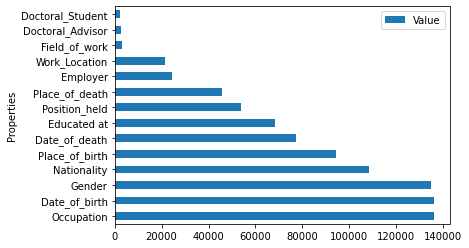

In [138]:
df.sort_values(ascending=False, by=["Value"]).plot.barh()